In [129]:
import datetime as dt
import os
import urllib
from pathlib import Path
from itertools import combinations
import h5py

import matplotlib.pyplot as plt
import numpy as np
import spiceypy as spice
from IPython.display import display, clear_output
from astropy.coordinates import spherical_to_cartesian
from scipy.spatial.distance import cdist
from scipy.spatial.transform import Rotation as R
from surrender.geometry import vec3, quat

import craterdetection.common.constants as const
from craterdetection.common.camera import Camera
from craterdetection.common.conics import generate_mask, conic_matrix, ellipse_axes, plot_conics, conic_center
from craterdetection.common.coordinates import suborbital_coords
from craterdetection.common.spice import get_sol_incidence, get_sun_pos, get_earth_pos
from craterdetection.common.surrender import setup_renderer
from craterdetection.matching.database import extract_robbins_dataset, load_craters
from craterdetection.matching.utils import eps_array




In [130]:
_BASE_URL = 'https://naif.jpl.nasa.gov/pub/naif/'
_KERNEL_ROOT = Path('../data/spice_kernels')
def download_kernel(file_path, base_url=_BASE_URL, base_folder=_KERNEL_ROOT):
    if isinstance(file_path, str):
        file_path = Path(file_path)

    local_path = base_folder / file_path
    url = base_url + file_path.as_posix()

    # Create necessary sub-directories in the DL_PATH direction
    local_path.parent.mkdir(parents=True, exist_ok=True)

    try:
        # If the file is not present in the download directory -> download it
        if not os.path.isfile(local_path):
            print(f"Downloading {url}", end="  ")
            # Download the file with the urllib  package
            urllib.request.urlretrieve(str(url), str(local_path))
            print("Done.")
        else:
            print(f"{base_folder / file_path} already exists!")
    except urllib.error.HTTPError as e:
        print(f"Error: \n{url} could not be found: ", e)

kernels_ = [
               'generic_kernels/lsk/naif0012.tls',
               'generic_kernels/pck/pck00010.tpc',
               'pds/data/lro-l-spice-6-v1.0/lrosp_1000/data/spk/de421.bsp',
               'pds/data/lro-l-spice-6-v1.0/lrosp_1000/data/pck/moon_pa_de421_1900_2050.bpc',
               'pds/data/lro-l-spice-6-v1.0/lrosp_1000/data/fk/moon_assoc_pa.tf',
               'pds/data/lro-l-spice-6-v1.0/lrosp_1000/data/fk/moon_080317.tf'
           ]
kernels = list(map(Path, kernels_))

for k in kernels:
    download_kernel(k)

spice.furnsh(list(map(lambda x: str(_KERNEL_ROOT / x), kernels)))
s = setup_renderer(raytracing=False)

..\data\spice_kernels\generic_kernels\lsk\naif0012.tls already exists!
..\data\spice_kernels\generic_kernels\pck\pck00010.tpc already exists!
..\data\spice_kernels\pds\data\lro-l-spice-6-v1.0\lrosp_1000\data\spk\de421.bsp already exists!
..\data\spice_kernels\pds\data\lro-l-spice-6-v1.0\lrosp_1000\data\pck\moon_pa_de421_1900_2050.bpc already exists!
..\data\spice_kernels\pds\data\lro-l-spice-6-v1.0\lrosp_1000\data\fk\moon_assoc_pa.tf already exists!
..\data\spice_kernels\pds\data\lro-l-spice-6-v1.0\lrosp_1000\data\fk\moon_080317.tf already exists!
Surrender Python Client
code revision : c17439eea9ae041bf49364d67a2a232fc89c1faa


In [131]:
# Constants:
sun_radius = 696342000
earth_radius = 6371e3
ua2km = 149597870.700
ua = ua2km * 1e3
R_moon = 1737.4

s.createBRDF('sun', 'sun.brdf', {})
s.createShape('sun', 'sphere.shp', {'radius': sun_radius})
s.createBody('sun', 'sun', 'sun', [])

s.createBRDF("mate", "mate.brdf", {})
s.createShape("earth_shape", "sphere.shp", {'radius': earth_radius})
s.createBody("earth", "earth_shape", "mate", ["earth.jpg"])

s.createBRDF('hapke', 'hapke.brdf', {})
s.createSphericalDEM('moon', 'FullMoon.dem', 'hapke', 'lroc_color_poles.tiff')
s.setObjectElementBRDF('moon', 'moon', 'hapke')
s.setObjectAttitude('moon', np.array([0, 0, 0, 1]))

s.setObjectPosition('moon', (0, 0, 0))
s.setObjectAttitude('moon', quat(vec3(1, 0, 0), 0))
s.setObjectAttitude('moon', R.from_euler('z', np.pi, degrees=False).as_quat())

In [132]:
resolution = (4092, 4092)
diamlims = (20, 200)
ellipse_limit = 1.2
arc_lims = 0.
lat = 30.
long = 100.
cam_alt = 700
date = dt.date(2021, 7, 22)


cam = Camera.from_coordinates(lat,
                              long,
                              cam_alt,
                              convert_to_radians=True,
                              resolution=resolution
                              )

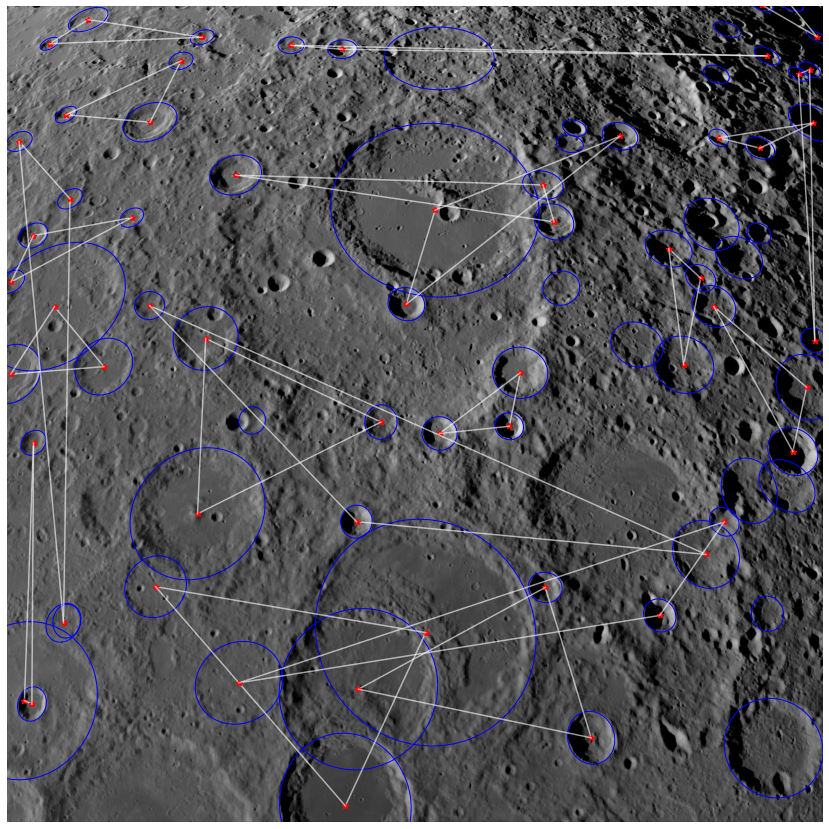

In [136]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(image, cmap="Greys_r")
ax.axis('off')
plot_conics(A_craters, ax=ax, resolution=resolution, rim_color='blue')
crater_triads = eps_array(len(A_craters), batch_size=20)
crater_centers = conic_center(A_craters)

for ct in crater_triads:
    for i, j in combinations(ct, 2):
        ci, cj = crater_centers[i], crater_centers[j]
        ax.plot(ci[0], ci[1], 'r*')
        ax.plot(cj[0], cj[1], 'r*')
        ax.plot((ci[0], cj[0]), (ci[1], cj[1]), 'w', alpha=0.6)


In [139]:
fig.savefig('output/cover_image.png', bbox_inches='tight', dpi=220)